gpu detected PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
class weights {0: 49.995740223463685, 1: 433.9024242424242, 2: 70.12135161606268, 3: 0.19953539964827496, 4: 0.236665443570647, 5: 11932.316666666668, 6: 25.77174226061915, 7: 5966.158333333334, 8: 4.7384936130782975, 9: 2.099404726995484}
Epoch 1/30
700/700 [==============================] - 2s 2ms/step - loss: 2.4075 - accuracy: 0.1401 - val_loss: 2.0857 - val_accuracy: 0.1471
Epoch 2/30
700/700 [==============================] - 1s 1ms/step - loss: 2.2183 - accuracy: 0.1517 - val_loss: 2.0357 - val_accuracy: 0.2105
Epoch 3/30
700/700 [==============================] - 1s 973us/step - loss: 1.9774 - accuracy: 0.1869 - val_loss: 2.0070 - val_accuracy: 0.2283
Epoch 4/30
700/700 [==============================] - 1s 977us/step - loss: 1.8950 - accuracy: 0.2134 - val_loss: 1.9542 - val_accuracy: 0.2600
Epoch 5/30
700/700 [==============================] - 1s 1ms/step - loss: 1.7792 - accuracy: 0.2412 - val_loss

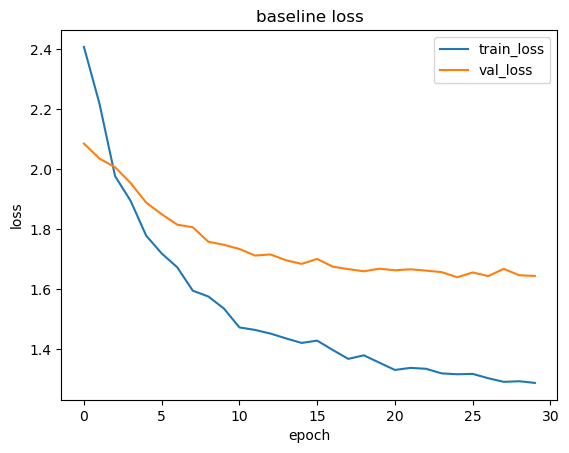

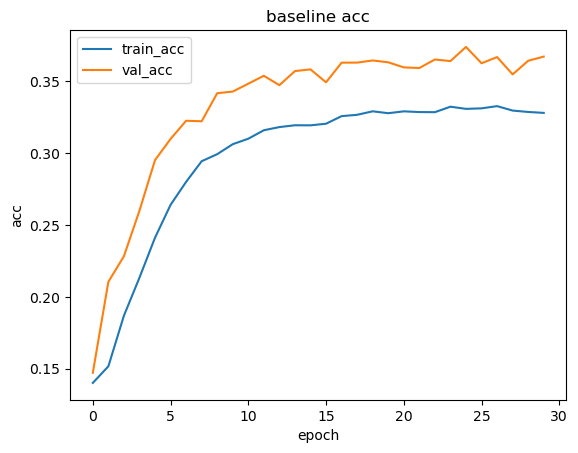

In [2]:
# minimal baseline mlp fast version with class weights

# speed settings
# enable xla tf32 and mixed precision
# use gpu memory growth

import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/cuda'

import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from sklearn.utils.class_weight import compute_class_weight

# xla and tf32
tf.config.optimizer.set_jit(True)
try:
    tf.config.experimental.enable_tensor_float_32_execution(True)
except:
    pass

# mixed precision fp16
mixed_precision.set_global_policy('mixed_float16')

# gpu memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('gpu detected', gpus[0])
    except:
        pass
else:
    print('no gpu detected running on cpu')

# load metadata
with open('../artifacts/metadata.json') as f:
    meta = json.load(f)

# load arrays
X_train = np.load('../artifacts/X_train.npy')
X_val   = np.load('../artifacts/X_val.npy')
y_train = np.load('../artifacts/y_train.npy')
y_val   = np.load('../artifacts/y_val.npy')

# one hot labels
num_classes = len(meta['label_classes'])
y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = keras.utils.to_categorical(y_val, num_classes)

# class weights to handle imbalance
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes.tolist(), weights.tolist()))
print('class weights', class_weights)

# simple scaling
X_mean = X_train.mean(axis=0)
X_std  = X_train.std(axis=0) + 1e-8
X_train_s = (X_train - X_mean) / X_std
X_val_s   = (X_val   - X_mean) / X_std
np.save('../artifacts/X_mean.npy', X_mean)
np.save('../artifacts/X_std.npy', X_std)

# cast inputs to float16 to save vram
X_train_s = X_train_s.astype('float16', copy=False)
X_val_s   = X_val_s.astype('float16', copy=False)

# fast dataset pipelines
BATCH = 1024  # increase until vram is almost full
train_ds = tf.data.Dataset.from_tensor_slices((X_train_s, y_train_oh)).cache().shuffle(10000).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val_s,   y_val_oh)).cache().batch(BATCH).prefetch(tf.data.AUTOTUNE)

# model
inp = keras.Input(shape=(X_train.shape[1],))
x = keras.layers.Dense(64, activation='relu')(inp)   # hidden layer
x = keras.layers.Dropout(0.2)(x)
out = keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)  # keep softmax fp32
model = keras.Model(inp, out)

# compile
opt = keras.optimizers.legacy.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=True)

# train with class weights
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=1,
    class_weight=class_weights
)

# plots
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('baseline loss')
plt.savefig('../artifacts/baseline_loss.png', dpi=150)

plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('epoch'); plt.ylabel('acc'); plt.legend(); plt.title('baseline acc')
plt.savefig('../artifacts/baseline_acc.png', dpi=150)

# save
model.save('../artifacts/baseline_model.keras')
with open('../artifacts/baseline_history.json','w') as f:
    json.dump(history.history, f)
